# Data Cleaning

This notebook is the continuation of my data science project after performing the [Exploratoty Analysis](http://www.kaggle.com/nikoladyulgerov/labelling-famous-landmarks-eda) (**EDA**) on **Google Landmark Recognition 2020** dataset. The aim of this step is to clean and prepare the image data with which I am going to feed later on the constructed models.

# Index of Contents

1. **Importing libraries**
2. **Approach overview**
3. **Data preparation**
4. **Image sizes**

# Importing libraries

The modules are the most basic and common one for this kind of work.

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

#Seed for making reproducible experiments
seed = 612

The next step is loading the dataset.

In [2]:
train_data = pd.read_csv("../input/landmark-recognition-2020/train.csv")
train_data.sample(5, random_state=seed)

,id,landmark_id
1154552,ec9e3d6f8dce016c,148331
270076,95c98d3b545c7f45,34452
952431,d22f5207d7734c80,123131
1039368,fcebb77d5d8ab9c8,134125
1410921,33338b5ad14b5653,181281


Once we have checked that is correctly loaded, we are ready for work.

# Approach Overview


The [Exploratoty Analysis](http://www.kaggle.com/nikoladyulgerov/labelling-famous-landmarks-eda) gave us clues about the nature of this particular dataset. Let's review some of its characteristics, just to sum up what we should do now to deal with it.

* Huge unbalanced distribution of classes
* High variance inside classes
* Different image sizes

Due to the computational limits I am experimenting with this project I am not going to use the entire dataset, it is impossible for me to handle this amount of data. That is why I will divide the process into two parts:

* First, set the model construction with the top `200` labels on Kaggle and Google Colab platform.
* Secondly, scale up the models with the top `2000` labels on Google Cloud.

Although these classes do not represent a high percent of the database, they have a great number of images what is the main reason why I have selected them. With that in mind, the balance of labels will be in some way guaranteed, although some variance stills remaining. However, it can be handle with simple techniques.

In [3]:
print("Number of total labels ",  train_data["landmark_id"].nunique())
print("Number of total images ", train_data.shape[0])

Number of total labels  81313
Number of total images  1580470


I am getting rid of the most frequent landmark of the dataset because as it was seen in the exploratory analysis it has a huge difference of images against the rest. My intention with this is to minimize the unbalance on the sample data.

In [4]:
n = 201
top_200 = train_data['landmark_id'].value_counts()[1:n].index.tolist()
images_200 = train_data.loc[train_data["landmark_id"].isin(top_200)]
print("Number of images of the top ",images_200["landmark_id"].nunique(), " landmarks: ", images_200.shape[0])

Number of images of the top  200  landmarks:  92465


In [5]:
n = 2001
top_2000 = train_data['landmark_id'].value_counts()[1:n].index.tolist()
images_2000 = train_data.loc[train_data["landmark_id"].isin(top_2000)]
print("Number of images of the top ",images_2000["landmark_id"].nunique(), " landmarks: ", images_2000.shape[0])

Number of images of the top  2000  landmarks:  362788


Before carrying on the data cleaning and preparation procees, let's take a look of the already sampled data.

Text(0.5, 1.0, 'Top 2000 most frequent landmarks')

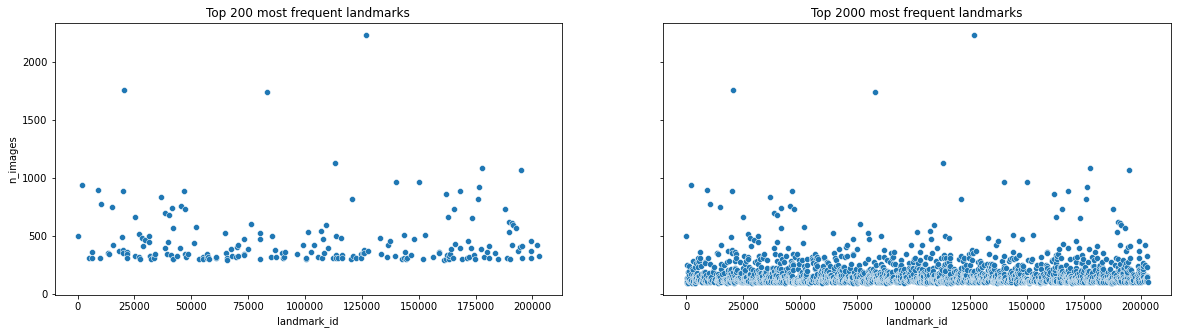

In [6]:
# Calculating the n_images per landmark
db1 = images_200.groupby(["landmark_id"]).size().reset_index(name='n_images')
db2 = images_2000.groupby(["landmark_id"]).size().reset_index(name='n_images')
#Plotting a scatterplot of the distribution
fig, axes = plt.subplots(1, 2,sharey = True, figsize = (20,5))

sns.scatterplot(ax=axes[0], x='landmark_id', y='n_images', data=db1, palette="mako")
axes[0].set_title("Top 200 most frequent landmarks")
sns.scatterplot(ax=axes[1], x='landmark_id', y='n_images', data=db2, palette="mako")
axes[1].set_title("Top 2000 most frequent landmarks")

As it was mentioned, the images per labels are in some way more balanced than before. However, there are some outstanding classes with a huge difference of images against the others. Also, looking to the right graph it is very clear that as the range of classes increases, the images per class decreases because the points are highly concentrated on the bottom of the scatter plot.

To reduce even more the imbalance among classes, I am going to perform a downsample of the outstanding classes. My aim with that is stablishing a uniform distribution among classes so that the performance of the models will not to be affected by this aspect.

In [7]:
def downsampling(data_df, counts_df, max_samples):
    # Get the oustanding classes to downsample
    outstand = counts_df[counts_df["n_images"]>=max_samples]
    rest = data_df[data_df["landmark_id"].isin(outstand["landmark_id"]) == False]
    # Random downsample of these classes to max_samples
    for row in outstand.itertuples():
        # Get max_samples for specific landmark_id
        temp_df = data_df[data_df["landmark_id"] == row.landmark_id].sample(max_samples, random_state = seed)
        
        rest = pd.concat([rest, temp_df], axis = 0)
        
    return rest

Text(0.5, 1.0, 'Top 2000 most frequent landmarks')

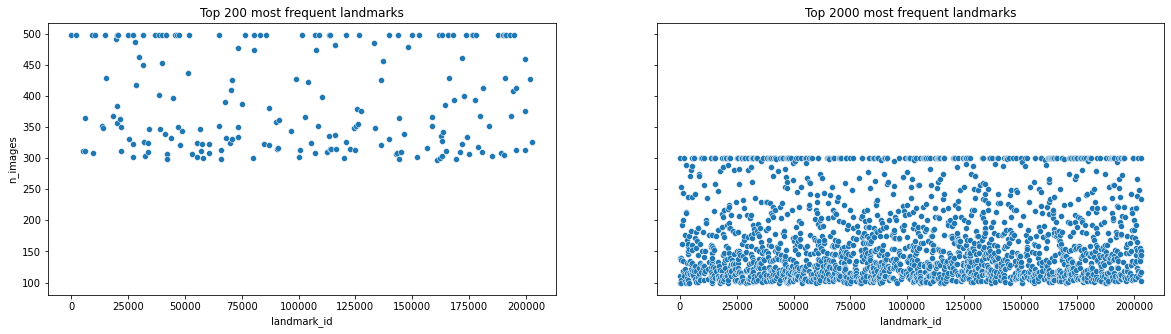

In [8]:
images_200 = downsampling(images_200, db1, db1['n_images'].min()+200) #Get the minimum samples per class and add some more
images_2000 = downsampling(images_2000, db2, db2['n_images'].min()+200)


# Calculating the n_images per landmark
db1 = images_200.groupby(["landmark_id"]).size().reset_index(name='n_images')
db2 = images_2000.groupby(["landmark_id"]).size().reset_index(name='n_images')
#Plotting a barplot of the distributions
fig, axes = plt.subplots(1, 2,sharey = True, figsize = (20,5))

sns.scatterplot(ax=axes[0], x='landmark_id', y='n_images', data=db1, palette="mako")
axes[0].set_title("Top 200 most frequent landmarks")

sns.scatterplot(ax=axes[1], x='landmark_id', y='n_images', data=db2, palette="flare")
axes[1].set_title("Top 2000 most frequent landmarks")

With the downsampling function the graphs have changed their shapes. Now all the classes have very similar number of images due to the reduction of the oustanding ones. Moreover, it is more noticeable that as the number of classes increase the number of images per class decrease. The maximum samples per class are setted according to the minimum number of images plus a certain "variation" (`200`), just to avoid losing too many images. 

Making some calculus we can stablish the proportion of the original dataset that will be used in further project steps.

In [9]:
print("Top 200 landmarks represent {:.2f} % of the entire dataset".format(images_200.shape[0]/train_data.shape[0] * 100))
print("Top 2000 landmarks represent {:.2f} % of the entire dataset".format(images_2000.shape[0]/train_data.shape[0] * 100))

Top 200 landmarks represent 4.94 % of the entire dataset
Top 2000 landmarks represent 20.90 % of the entire dataset


Although I am not going to make use of a huge part of the dataset, these percentages represent a big number of images as we have seen previously. The problem is simplified due to time and cost constraints of the development of the project.

# Data Preparation

This stage consist on the preparation of the directory structure to be downloaded from the Kaggle platform. I will divide each of the two sample datasets obtained before in three main folders: **train**, **validation** and finally **test**. Here comes the other part of simplifying the problem. The test sets with which I am going to work are entirely composed by landmark images which is not the case for the given test folder by the Google competition.

Following the standard norms and knowing that the sample datasets are big enough, the holdout of images that corresponds to each partition are going to be: `70%` train, `20%` validation and `10%` test.

The way of making the directory structure comes from how **Keras** works. The idea is to construct the optimal way to feed the models and do not waste time making unnecesary searches while training and evaluating them. It will look something like the following composition:

`--data
    |--train
        |--landmark_1
            |--image_1_landmark_1
            |--image_2_landmark_1
            ...
        |--landmark_2
        ...
    |--validation
    |--test
  `

Before starting, there is something important to consider, the classes are not perfeclty balanced, so it is a good practice to make a stratified splits. For this task, I am going to use the well known module `sklearn` that has some built-in functions that make it easy.

In [10]:
X, y = images_200["id"].to_list(), images_200["landmark_id"].to_list()
X_train, X_test_200, y_train, y_test_200 = train_test_split(X, y, test_size = 0.1, random_state = seed, stratify = y)

Now, the same process must be applied again in order to get the validation split. For that, the split is applied on the remaining train set.

In [11]:
X_train_200, X_val_200, y_train_200, y_val_200 = train_test_split(X_train, y_train, test_size = 0.22, random_state = seed, stratify = y_train) # 0.22 x 0.9 = 0.2

For an ease of operations later, let's build the data frames for each set.

In [12]:
train = { 'id': X_train_200, 'landmark_id': y_train_200 }  
val = { 'id': X_val_200, 'landmark_id': y_val_200 }  
test = { 'id': X_test_200, 'landmark_id': y_test_200 }  

train_200 = pd.DataFrame(train)
val_200 = pd.DataFrame(val)
test_200 = pd.DataFrame(test)

Making sure, the process is completed correctly

In [13]:
train_200.sample(5, random_state=seed)

,id,landmark_id
27431,c6e5cd77e07d790e,96663
4984,4f0b67a9e9d787a5,193550
47418,8778766758dad55b,174181
23008,f93c4d1a4522e549,158818
47407,0317b74af8867bef,33992


In [14]:
val_200.sample(5, random_state=seed)

,id,landmark_id
1783,98cb2f29a86f54ba,73300
14941,b85390b455e1cc74,194914
13852,3df95bf5f7faf7c1,168106
7918,d5a83a10a452150c,125425
10040,01835434e0b5865d,139894


In [15]:
test_200.sample(5, random_state=seed)

,id,landmark_id
6648,ffb1c6a8f40e5d58,70644
7552,ad80447db3ca58e2,21703
290,6ed5037a206525ba,80147
256,a42afeab0a7c608f,113209
1252,d42b8d0986fcb2ee,146497


Repeat the same with the sample of 2000 labels.

In [16]:
X, y = images_2000["id"].to_list(), images_2000["landmark_id"].to_list()
X_train, X_test_2000, y_train, y_test_2000 = train_test_split(X, y, test_size = 0.1, random_state = seed, stratify = y)

In [17]:
X_train_2000, X_val_2000, y_train_2000, y_val_2000 = train_test_split(X_train, y_train, test_size = 0.22, random_state = seed, stratify = y_train) # 0.22 x 0.9 = 0.2

In [18]:
train = { 'id': X_train_2000, 'landmark_id': y_train_2000 }  
val = { 'id': X_val_2000, 'landmark_id': y_val_2000 }  
test = { 'id': X_test_2000, 'landmark_id': y_test_2000 }  

train_2000 = pd.DataFrame(train)
val_2000 = pd.DataFrame(val)
test_2000 = pd.DataFrame(test)

In [19]:
train_2000.sample(5, random_state=seed)

,id,landmark_id
41479,7ea1f47a50e4e445,13807
123950,404bc4216befc2f0,123315
220037,eab86dc6ed6a9ab5,42547
204851,bcc590cf179dea09,72475
186503,540d0cab3ab58d77,27


In [20]:
val_2000.sample(5, random_state=seed)

,id,landmark_id
49223,d1adfed2ac419a67,35628
4936,d83515c53f1d60f2,202814
35595,0d3d2bf9d027ea06,155750
11511,90cda3e9c81a861a,78791
43934,c06c7e9013bf3489,58893


In [21]:
test_2000.sample(5, random_state=seed)

,id,landmark_id
25480,62595c237f13f06f,9070
19577,34db7e9a5947000e,105924
11132,f1dfbf4d6eea30cd,93869
23298,366b228953441b28,193938
20980,ed9af2f5f0fc1144,108472


Before making the directories, let's save the `csv` files with the original paths. It is a good idea to keep track of the images we are going to use. By this way further experiments can be reproducible and easily shareable with the community.

In [22]:
def build_paths(df):
    paths = ["../input/landmark-recognition-2020/train/{}/{}/{}/{}.jpg".format(row.id[0],row.id[1],row.id[2],row.id) for row in df.itertuples()]
    df['path'] = paths
    return df

In [23]:
train_200 = build_paths(train_200)
val_200 = build_paths(val_200)
test_200 = build_paths(test_200)

Checking everything is correct.

In [24]:
train_200.sample(5, random_state=seed)

,id,landmark_id,path
27431,c6e5cd77e07d790e,96663,../input/landmark-recognition-2020/train/c/6/e...
4984,4f0b67a9e9d787a5,193550,../input/landmark-recognition-2020/train/4/f/0...
47418,8778766758dad55b,174181,../input/landmark-recognition-2020/train/8/7/7...
23008,f93c4d1a4522e549,158818,../input/landmark-recognition-2020/train/f/9/3...
47407,0317b74af8867bef,33992,../input/landmark-recognition-2020/train/0/3/1...


In [25]:
val_200.sample(5, random_state=seed)

,id,landmark_id,path
1783,98cb2f29a86f54ba,73300,../input/landmark-recognition-2020/train/9/8/c...
14941,b85390b455e1cc74,194914,../input/landmark-recognition-2020/train/b/8/5...
13852,3df95bf5f7faf7c1,168106,../input/landmark-recognition-2020/train/3/d/f...
7918,d5a83a10a452150c,125425,../input/landmark-recognition-2020/train/d/5/a...
10040,01835434e0b5865d,139894,../input/landmark-recognition-2020/train/0/1/8...


In [26]:
test_200.sample(5, random_state=seed)

,id,landmark_id,path
6648,ffb1c6a8f40e5d58,70644,../input/landmark-recognition-2020/train/f/f/b...
7552,ad80447db3ca58e2,21703,../input/landmark-recognition-2020/train/a/d/8...
290,6ed5037a206525ba,80147,../input/landmark-recognition-2020/train/6/e/d...
256,a42afeab0a7c608f,113209,../input/landmark-recognition-2020/train/a/4/2...
1252,d42b8d0986fcb2ee,146497,../input/landmark-recognition-2020/train/d/4/2...


Saving the files.

In [27]:
train_200.to_csv('train_200.csv',index=False)
val_200.to_csv('val_200.csv',index=False)
test_200.to_csv('test_200.csv',index=False)

The same operation with the other sample.

In [28]:
train_2000 = build_paths(train_2000)
val_2000 = build_paths(val_2000)
test_2000 = build_paths(test_2000)

Checking everything is correct.

In [29]:
train_2000.sample(5, random_state=seed)

,id,landmark_id,path
41479,7ea1f47a50e4e445,13807,../input/landmark-recognition-2020/train/7/e/a...
123950,404bc4216befc2f0,123315,../input/landmark-recognition-2020/train/4/0/4...
220037,eab86dc6ed6a9ab5,42547,../input/landmark-recognition-2020/train/e/a/b...
204851,bcc590cf179dea09,72475,../input/landmark-recognition-2020/train/b/c/c...
186503,540d0cab3ab58d77,27,../input/landmark-recognition-2020/train/5/4/0...


In [30]:
val_2000.sample(5, random_state=seed)

,id,landmark_id,path
49223,d1adfed2ac419a67,35628,../input/landmark-recognition-2020/train/d/1/a...
4936,d83515c53f1d60f2,202814,../input/landmark-recognition-2020/train/d/8/3...
35595,0d3d2bf9d027ea06,155750,../input/landmark-recognition-2020/train/0/d/3...
11511,90cda3e9c81a861a,78791,../input/landmark-recognition-2020/train/9/0/c...
43934,c06c7e9013bf3489,58893,../input/landmark-recognition-2020/train/c/0/6...


In [31]:
test_2000.sample(5, random_state=seed)

,id,landmark_id,path
25480,62595c237f13f06f,9070,../input/landmark-recognition-2020/train/6/2/5...
19577,34db7e9a5947000e,105924,../input/landmark-recognition-2020/train/3/4/d...
11132,f1dfbf4d6eea30cd,93869,../input/landmark-recognition-2020/train/f/1/d...
23298,366b228953441b28,193938,../input/landmark-recognition-2020/train/3/6/6...
20980,ed9af2f5f0fc1144,108472,../input/landmark-recognition-2020/train/e/d/9...


Saving the files.

In [32]:
train_2000.to_csv('train_2000.csv',index=False)
val_2000.to_csv('val_2000.csv',index=False)
test_2000.to_csv('test_2000.csv',index=False)

Finally, we are ready for making the directory structure.

In [33]:
def making_folders(df, c_col, i_col, path):
    shutil.os.mkdir(path)
    classes = df[c_col].unique()
    for c in tqdm(classes):
        f_path = f"{path}{c}"
        shutil.os.mkdir(f_path)
        imgs = df.loc[df[c_col] == c][i_col].to_list()
        for i in imgs:
            image_path = "../input/landmark-recognition-2020/train/{}/{}/{}/{}.jpg".format(i[0],i[1],i[2],i)
            shutil.copy(image_path, f_path)

In [34]:
# making_folders(train_200, "landmark_id", "id", "..train_200/")
# making_folders(val_200, "landmark_id", "id", "..val_200/")
making_folders(test_200, "landmark_id", "id", "..test_200/")
# making_folders(train_2000, "landmark_id", "id", "..train_2000/")
# making_folders(val_2000, "landmark_id", "id", "..val_2000/")
# making_folders(test_200, "landmark_id", "id", "..test_200/")

  0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
! ls -a

.   ..test_200		test_200.csv   train_200.csv   val_200.csv
..  __notebook__.ipynb	test_2000.csv  train_2000.csv  val_2000.csv


At this point, some of the limitations of the Kaggle platform appeared. There is a constraint about the space disk one can use, so this task must be done one by one. That is the reason the code above is commented. Moreover, it is impossible to publish the notebook with all the created folders because the **output** or **working directory** only supports `5GB`. What I did is download one by one and just the first part, the dataset with the 200 labels because the other one exceeded all the limits. My intentions is once constructed the models, come back and upgrade to Google Cloud Platform and scale up the builded neural networks with more classes and images.

# Image sizes

After thinking about the problem with the different image size of the dataset I considered to download the original ones. The main is reason is that I can always go back one step instead of resizing all without already knowing what type of neural network I am going to construct. So, I postpone this task for the next step to make it more suitable and with the aim of a bigger control on the factors of the efficiency of the future models.

----Note **Latest Version**----

Once I modeled the first neural network I found that resizing the images with ImageDataGenerator class or special Keras layers, the time per epoch was very high due to the sizing task. For each execution, the images were resized what was a waste of time. To make the process faster what I did was resizing all images once and save them, ready to use without waiting too much. 

The other problem that comes with resizing the images is deciding what size to give them. A very big size increase the time to process because there are more features to exctract from an image. On the other hand, a smaller size decrease the execution time, but some features can be overlooked by the neural network.

In [36]:
def resize(path, size):
    subfolders = [f.path for f in os.scandir(path) if f.is_dir()]
    for s in tqdm(subfolders):
        for i in os.listdir(s):
            full_path = os.path.join(s,i)
            if os.path.isfile(full_path):
                im = Image.open(full_path)
                imResize = im.resize(size, Image.ANTIALIAS)
                imResize.save(full_path)

In [37]:
train = "..train_200/"
val = "..val_200/"
test = "..test_200/"

# resize(train, (256,256))
# resize(val, (256,256) )
resize(test, (256,256)) 

  0%|          | 0/200 [00:00<?, ?it/s]

In [38]:
! zip -qr test_200.zip "..test_200/"